In [3]:
import sys; sys.path.append("../../wwa"); from wwa import *

mapproj = cartopy.crs.PlateCarree()

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/"

Xn,Xx,Yn,Yx = [0,35,55,75]
xn,xx,yn,yx = [4,30,60,72]

sf = gpd.read_file("sf_fennoscandia")

# Coordinates of sites where records were observed

In [ ]:
# # locations of records
# sites = pd.read_csv("data/fs-heat-records.csv", index_col = "Site")
# px = pd.DataFrame.from_dict({k : get_latlon(k+", "+r.Country) for k,r in sites.iterrows()}).transpose()

# sites = merge_byindex([sites, px])
# sites.to_csv("data/fs-heat-records_with-coords.csv")

In [ ]:
# list of names that were updated manually from the original reported list
# corrected_names =  ["Meraker, Norway","Sunndalsora, Norway", "Varkaus, Finland", "Hailuoto, Finland", "Raahe, Finland", 
#                     "Ruukki, Finland", "Buholmrasa, Norway", "Skelleftea, Sweden", "Sarpsborg, Norway"]

In [9]:
sites = pd.read_csv("data/fs-heat-records_with-coords.csv", index_col = 0)

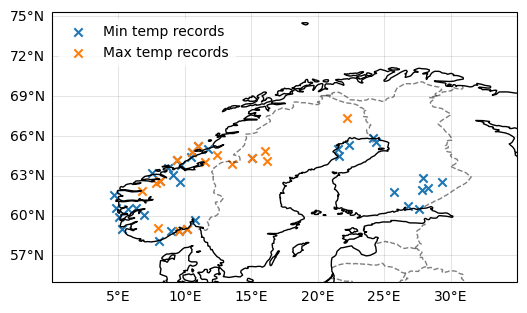

In [10]:
fig, ax = plt.subplots(figsize = (6,6), subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, dpi = 100)

for rt in ["min", "max"]:
    ax.scatter(sites.loc[sites.rtype == rt, "lon"], sites.loc[sites.rtype == rt, "lat"], marker = "x")

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

ax.legend(["Min temp records", "Max temp records"], loc = "upper left", edgecolor = "w")
plt.savefig("fig/record-locations.png")

# ERA5

## Maps of daily anomalies during July

In [61]:
fnm = "era5_tmax_daily_eu_extended_0-35E_55-75N_-999-lastyear.nc"

tx = wrap_lon(xr.open_dataset(fpath+fnm))
tx = tx[list(tx.data_vars)[0]]

lsm = xr.open_dataset(fpath+"era5_000000_lsm_eu.nc").lsm.squeeze(drop = True).rename(latitude = "lat", longitude = "lon").sel(lon = tx.lon, lat = tx.lat)
tx = tx.where(lsm > 0.5)

tx_clim07 = tx.groupby("time.month")[7].sel(time = slice("1990","2020")).mean("time")
anom = tx - tx_clim07

px = sites = pd.read_csv("data/fs-heat-records_with-coords.csv", index_col = 0)

intvl = 5

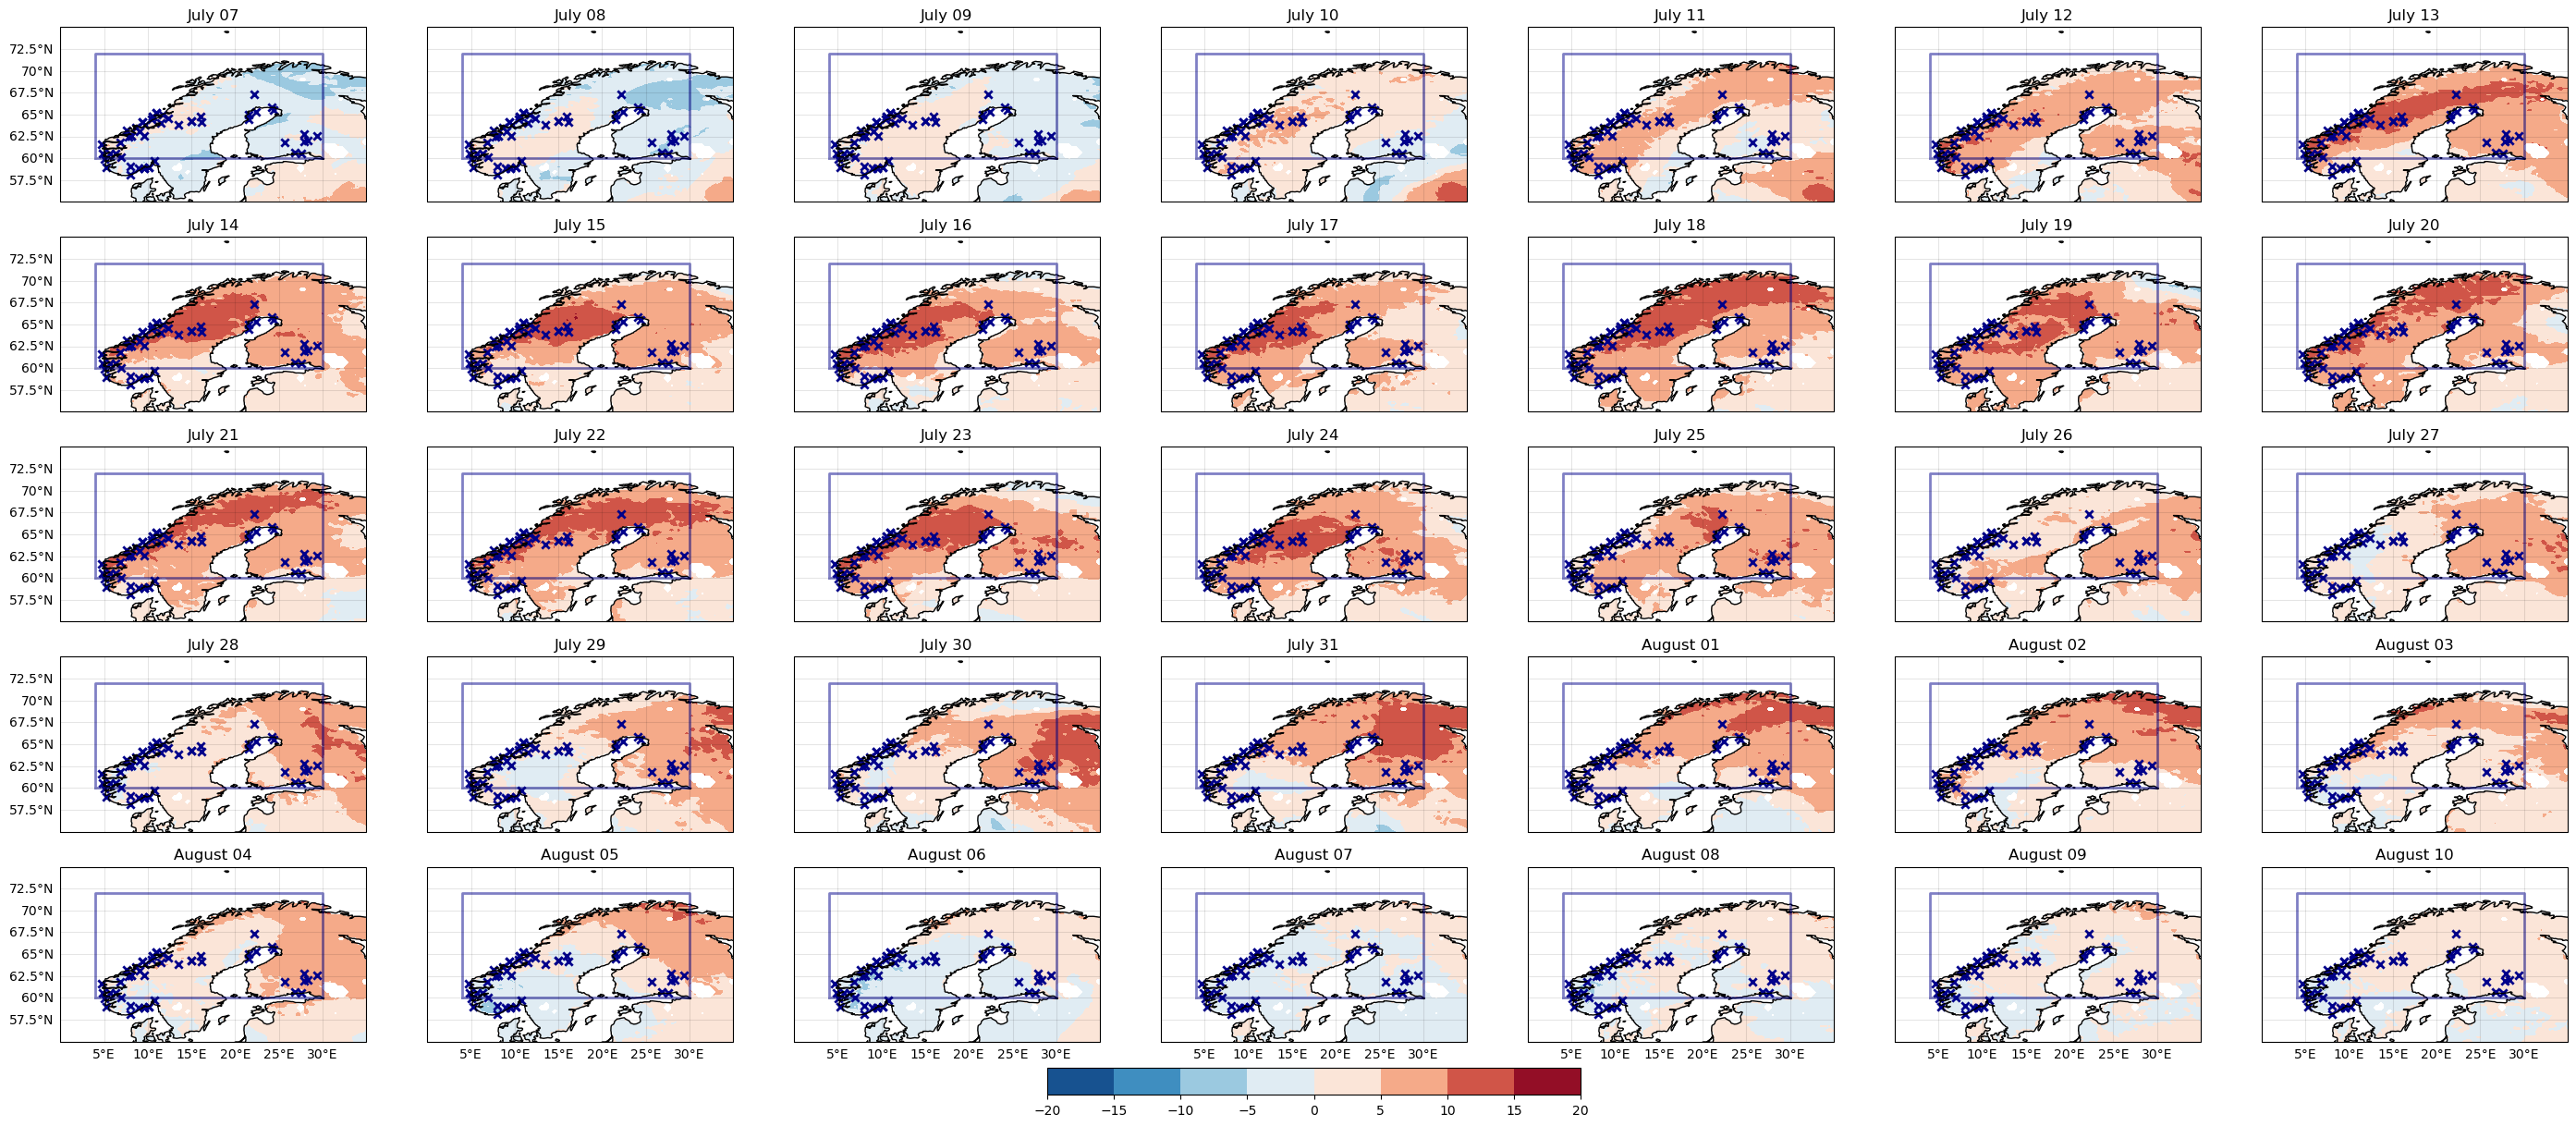

In [62]:
days = anom.sel(time = slice("2025-07-07", None)).isel(time = slice(None, -1))
nc = 7; nr = int(np.ceil(len(days)/nc))

xn,xx,yn,yx = [4,30,60,72]

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), subplot_kw = {"projection" : mapproj})

max_t = int(np.ceil(max(np.abs(days.min()), days.max()) / intvl) * intvl)
    
for i in range(len(days)):
    ax = axs.flatten()[i]
    da = days.isel(time = i)
    
    cbar = ax.contourf(da.lon, da.lat, da, levels = range(-max_t,max_t + intvl,intvl), cmap = "RdBu_r")
    ax.coastlines()
    ax.set_title(da.time.dt.strftime("%B %d").values)
    ax.gridlines(color = "k", alpha = 0.1)
    
    ax.scatter(px.lon, px.lat, marker = "x", color = "darkblue", lw = 2)
    
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    
for ax in axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])
for ax in axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])

for i in range(len(days), nc*nr): axs.flatten()[i].set_axis_off()

    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.025, pad = 0.025)
plt.savefig("fig/daily-anomalies_"+"_".join(fnm.split("_")[:2]))

## Seasonal cycle / accumulations

In [63]:
fnm = "era5_tmax_daily_eu_extended_0-35E_55-75N_-999-lastyear.nc"

tx = wrap_lon(xr.open_dataset(fpath+fnm))
tx = tx[list(tx.data_vars)[0]]

lsm = xr.open_dataset(fpath+"era5_000000_lsm_eu.nc").lsm.squeeze(drop = True).rename(latitude = "lat", longitude = "lon").sel(lon = tx.lon, lat = tx.lat)
tx = tx.where(lsm > 0.5)

ts = tx.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lat", "lon"])

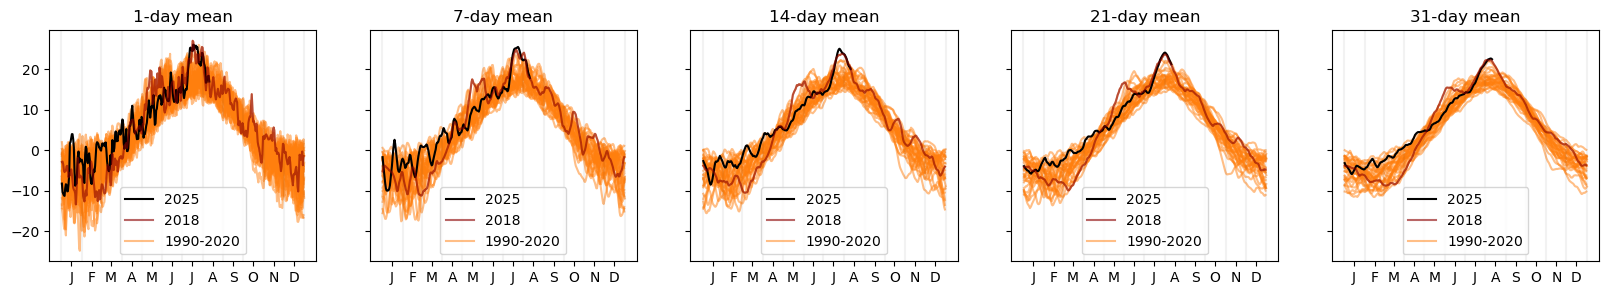

In [64]:
ndays = [1,7,14,21,31]

nc = len(ndays); nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.35)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

for i in range(nc):
    ax = axs[i]
    nd = ndays[i]
    
    ts_nday = ts.rolling(time = nd).mean()
    
    y = 2025; ts_y = ts_nday.sel(time = ts.time.dt.year == y); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    y = 2018; ts_y = ts_nday.sel(time = ts.time.dt.year == y); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", alpha = 0.6, label = "2018", zorder = 99)

    for y in range(1990,2020):
        ts_y = ts_nday.sel(time = ts.time.dt.year == y)
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
        
    ax.set_title(str(nd)+"-day mean")

    ax.legend(["2025", "2018", "1990-2020"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

# ylim = ax.get_ylim()
# ax.add_patch(Rectangle((77, 0), 10, ylim[1]+10, color = "gold", alpha = 0.3))
# ax.set_ylim(ylim)

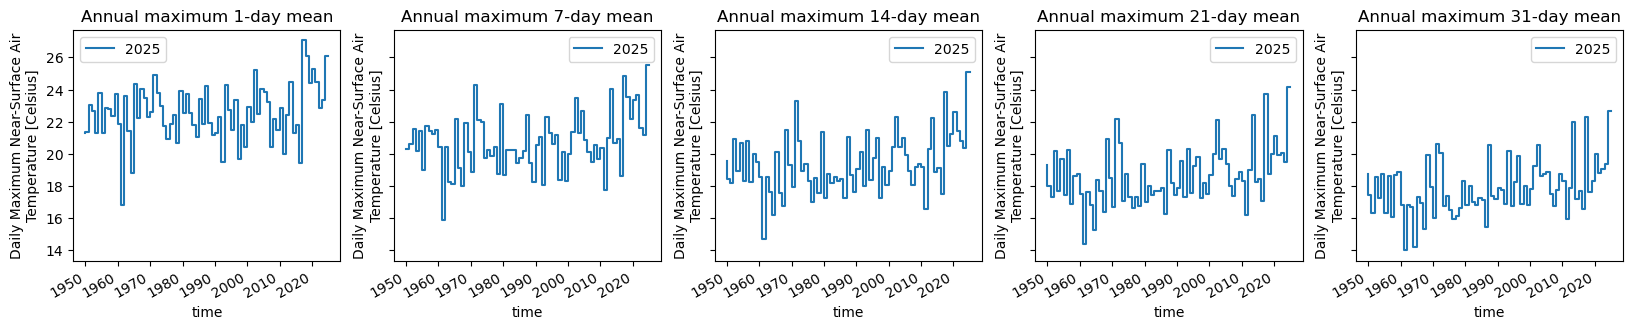

In [65]:
nc = len(ndays); nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.35)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

for i in range(nc):
    ax = axs[i]
    nd = ndays[i]
    
    txnx = ts.rolling(time = nd).mean().resample(time = "AS").max()
    txnx.plot(ax = ax, drawstyle = "steps")
        
    ax.set_title("Annual maximum "+str(nd)+"-day mean")

    ax.legend(["2025", "1990-2020"])


## Map of gridded trend

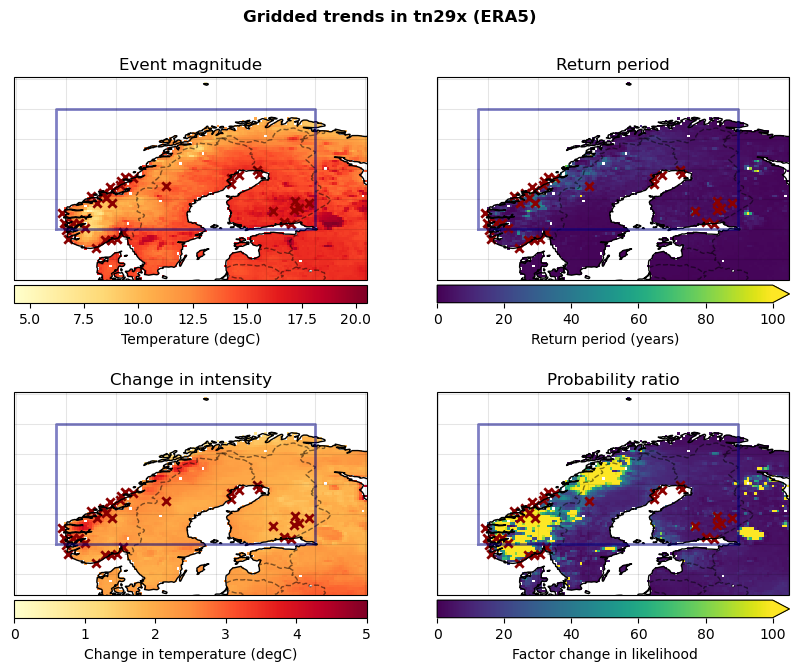

In [4]:
fnm = "gridded-trend_tn29x_era5.nc"

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# load gridded model results
res = xr.open_dataset(fnm)

# load locations of reported records
px = pd.read_csv("data/fs-heat-records_with-coords.csv", index_col = 0)
if "tn" in fnm:
    px = px.loc[px.rtype == "min"]
else:
    px = px.loc[px.rtype == "max"]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = 2; nc = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3.75), dpi = 100, subplot_kw = {"projection" : mapproj})
plt.subplots_adjust(hspace = 0.2)
axs = axs.flatten()

cbar_kwargs = {"location" : "bottom", "pad" : 0.02}

res.event_magnitude.plot(ax = axs[0], cmap = "YlOrRd", cbar_kwargs = cbar_kwargs | {"label" : "Temperature (degC)"})
axs[0].set_title("Event magnitude")

res.return_period.plot(ax = axs[1], cmap = "viridis", vmin = 0, vmax = 100, cbar_kwargs = cbar_kwargs | {"label" : "Return period (years)"})
axs[1].set_title("Return period")

res.dI_abs.plot(ax = axs[2], cmap = "YlOrRd", vmin = 0, vmax = 5, cbar_kwargs = cbar_kwargs | {"label" : "Change in temperature (degC)"})
axs[2].set_title("Change in intensity")

res.PR.plot(ax = axs[3], cmap = "viridis", vmin = 0, vmax = 100, cbar_kwargs = cbar_kwargs | {"label" : "Factor change in likelihood"})
axs[3].set_title("Probability ratio")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1)

    ax.scatter(px.lon, px.lat, marker = "x", color = "darkred", lw = 2)
    
plt.suptitle("Gridded trends in "+fnm.split("_")[1]+" ("+fnm.split("_")[-1][:-3].upper()+")", fontweight = "bold", y = 0.95)
    
plt.savefig("fig/"+fnm[:-3]+".png")

# E-Obs

_Data currently only available until end of June so can't make daily anomaly maps_

## Map of gridded trend

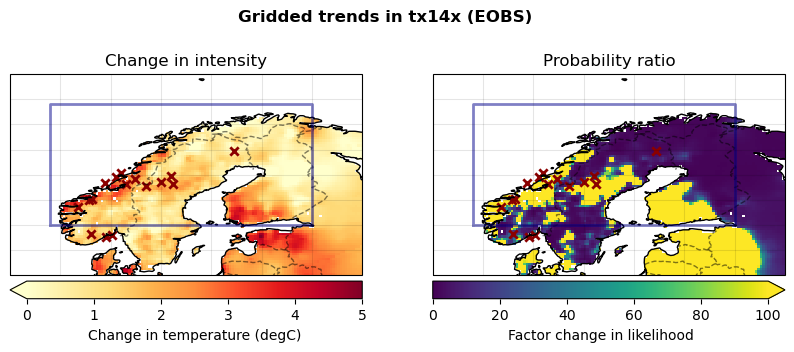

In [9]:
fnm = "gridded-trend_tx14x_eobs.nc"

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# load gridded model results
res = xr.open_dataset(fnm)

# load locations of reported records
px = pd.read_csv("data/fs-heat-records_with-coords.csv", index_col = 0)
if "tn" in fnm:
    px = px.loc[px.rtype == "min"]
else:
    px = px.loc[px.rtype == "max"]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = 1; nc = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3.75), dpi = 100, subplot_kw = {"projection" : mapproj})
plt.subplots_adjust(hspace = 0.2)
axs = axs.flatten()

cbar_kwargs = {"location" : "bottom", "pad" : 0.02}

# res.event_magnitude.plot(ax = axs[0], cmap = "YlOrRd", cbar_kwargs = cbar_kwargs | {"label" : "Temperature (degC)"})
# axs[0].set_title("Event magnitude")

# res.return_period.plot(ax = axs[1], cmap = "viridis", vmin = 0, vmax = 100, cbar_kwargs = cbar_kwargs | {"label" : "Return period (years)"})
# axs[1].set_title("Return period")

res.dI_abs.plot(ax = axs[0], cmap = "YlOrRd", vmin = 0, vmax = 5, cbar_kwargs = cbar_kwargs | {"label" : "Change in temperature (degC)"})
axs[0].set_title("Change in intensity")

res.PR.plot(ax = axs[1], cmap = "viridis", vmin = 0, vmax = 100, cbar_kwargs = cbar_kwargs | {"label" : "Factor change in likelihood"})
axs[1].set_title("Probability ratio")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1)

    ax.scatter(px.lon, px.lat, marker = "x", color = "darkred", lw = 2)
    
plt.suptitle("Gridded trends in "+fnm.split("_")[1]+" ("+fnm.split("_")[-1][:-3].upper()+")", fontweight = "bold", y = 0.95)
    
plt.savefig("fig/"+fnm[:-3]+".png")

# MSWX

In [ ]:
tx = xr.open_dataset("data/tmax_mswx.nc").tmax

lsm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(tx.lon, tx.lat)
tx = tx.where(lsm == 0)

days = tx.sel(time = slice("2025-07", None))

intvl = 5

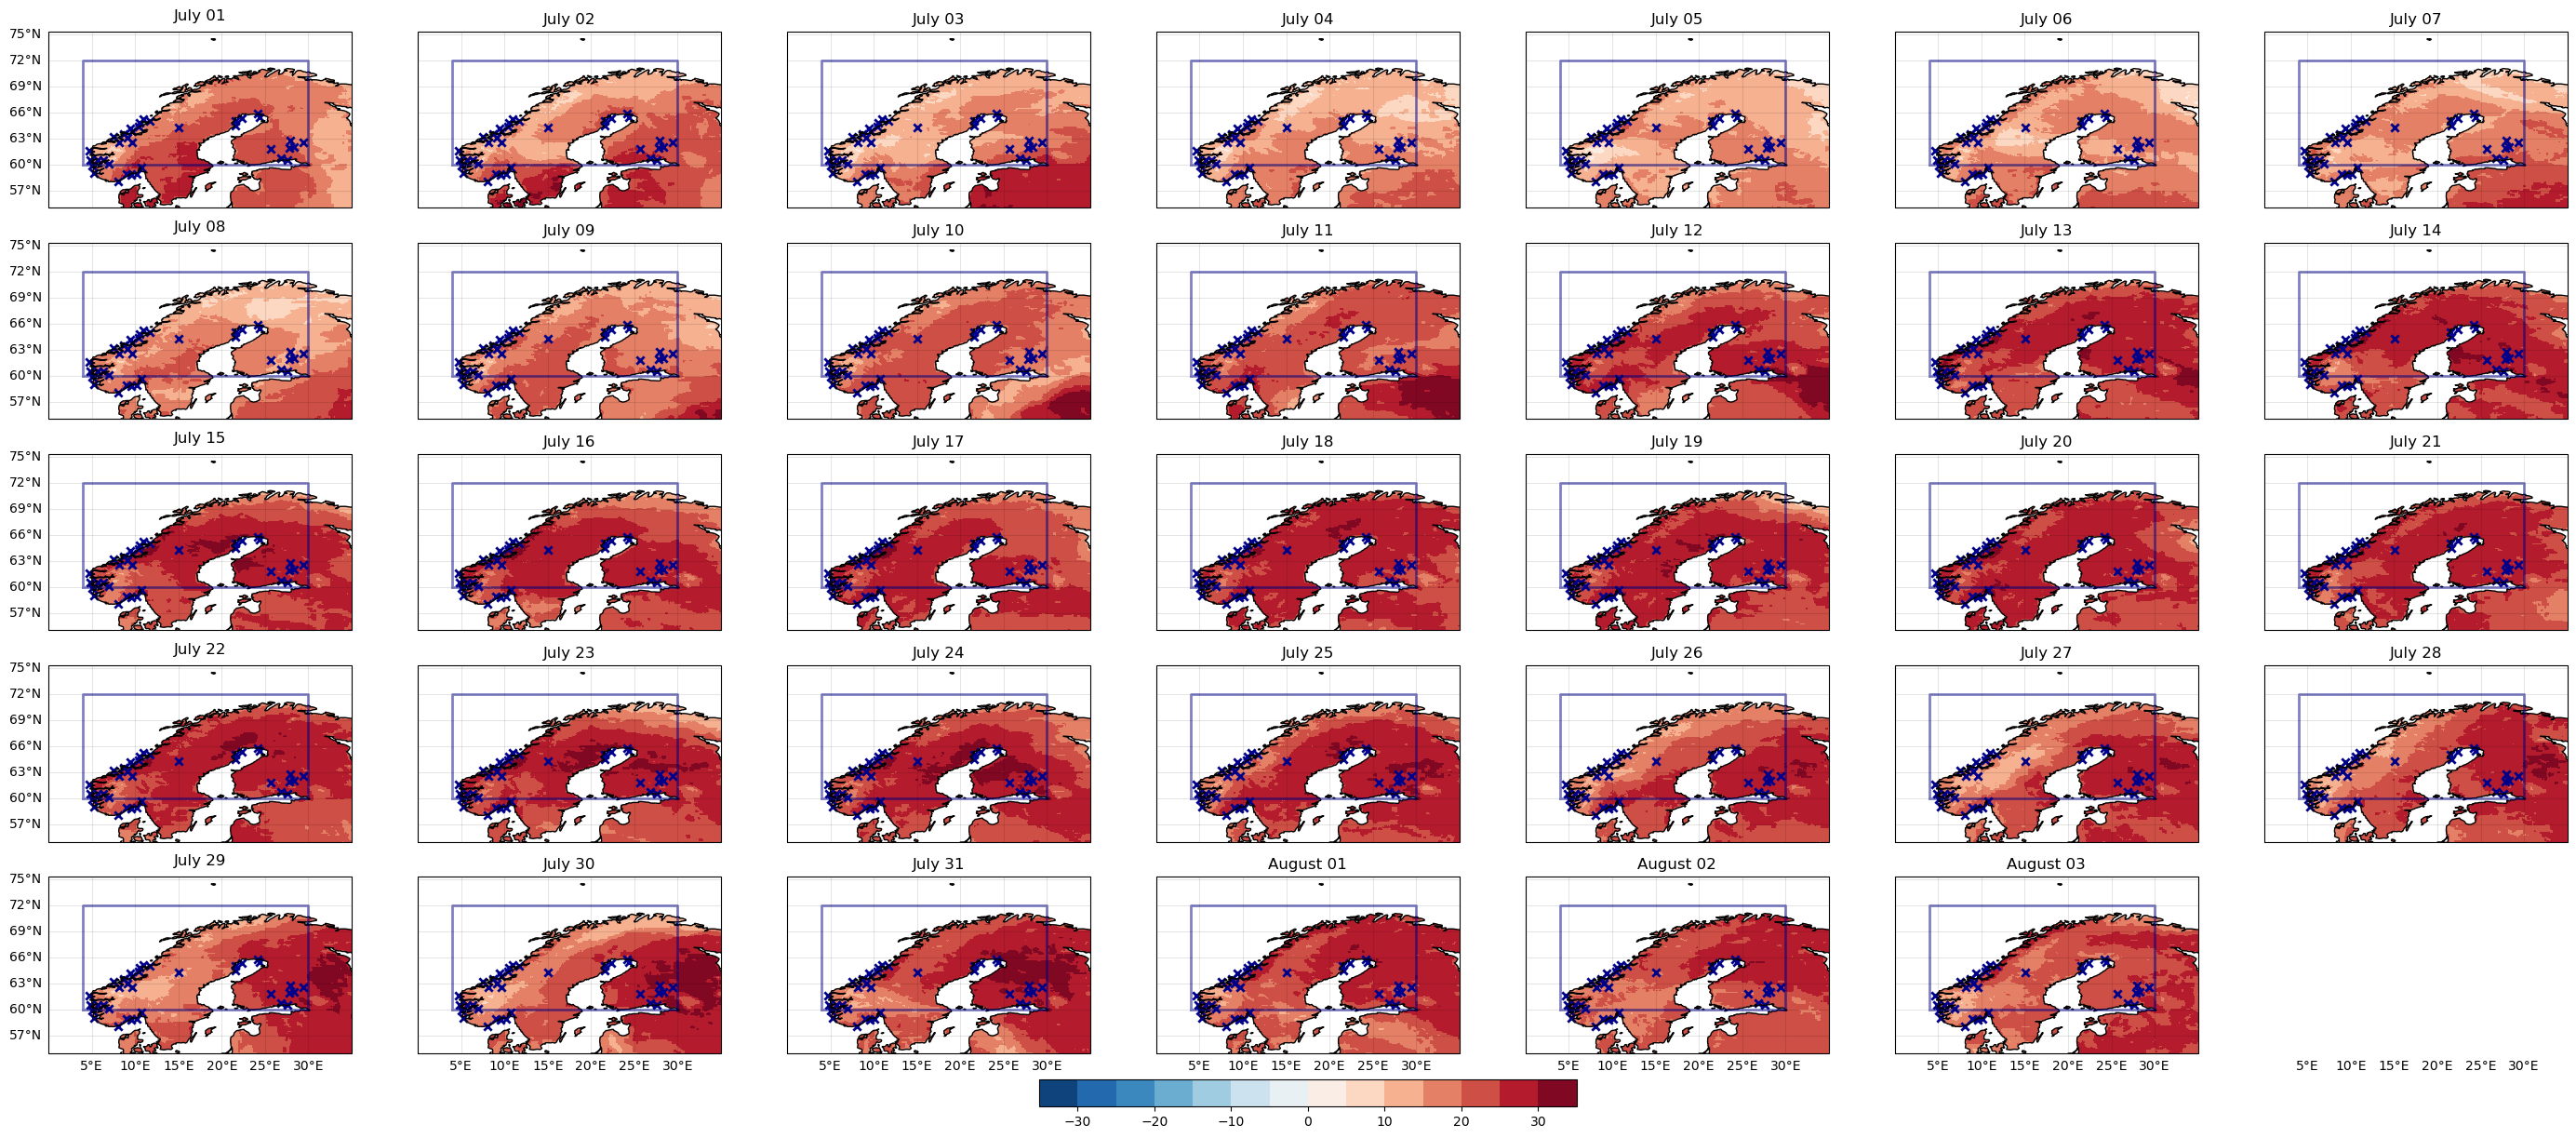

In [ ]:
nc = 7; nr = int(np.ceil(len(days)/nc))

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, sharex = True, sharey = True)

for i in range(len(days)):
    ax = axs.flatten()[i]
    da = days.isel(time = i)

    max_t = int(np.ceil(max(np.abs(days.min()), days.max()) / intvl) * intvl)
    
    cbar = ax.contourf(da.lon, da.lat, da, levels = range(-max_t,max_t + intvl,intvl), cmap = "RdBu_r")
    ax.coastlines()
    ax.set_title(da.time.dt.strftime("%B %d").values)
    ax.gridlines(color = "k", alpha = 0.1)
    
    ax.scatter(px.lon, px.lat, marker = "x", color = "darkblue", lw = 2)
    
    ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)
    
for ax in axs[-1,:]: ax.gridlines(alpha = 0, draw_labels = ["bottom"])
for ax in axs[:,0]: ax.gridlines(alpha = 0, draw_labels = ["left"])

for i in range(len(days), nc*nr): axs.flatten()[i].set_axis_off()

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.025, pad = 0.025)

# Diurnal range

In [2]:
ds_nm = "eobs"

df = merge_byindex([pd.read_csv("data/"+varnm+"-daily_"+ds_nm+".csv", index_col = "time", parse_dates = ["time"]) for varnm in ["tx", "tn"]])
df["drange"] = df.iloc[:,0] - df.iloc[:,1]

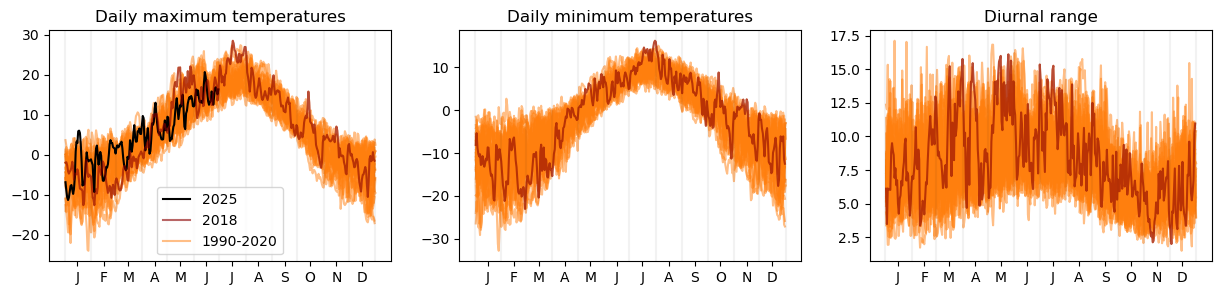

In [3]:
nc = len(df.columns); nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True, sharey = False)
plt.subplots_adjust(hspace = 0.35)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

for i in range(nc):
    cnm = df.columns[i]
    ax = axs[i]
    y = 2025; ts_y = df.loc[str(y)]; ax.plot(ts_y.index.dayofyear, ts_y[cnm], color = "k", label = "2025", zorder = 99)
    y = 2018; ts_y = df.loc[str(y)]; ax.plot(ts_y.index.dayofyear, ts_y[cnm], color = "darkred", alpha = 0.6, label = "2018", zorder = 99)
    
    for y in range(1990,2020):
        ts_y = df.loc[str(y)]
        ax.plot(ts_y.index.dayofyear, ts_y[cnm], color = "tab:orange", alpha = 0.5, label = "_years")
        
    ax.set_title(["Daily maximum temperatures", "Daily minimum temperatures", "Diurnal range"][i])
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
axs[0].legend(["2025", "2018", "1990-2020"])

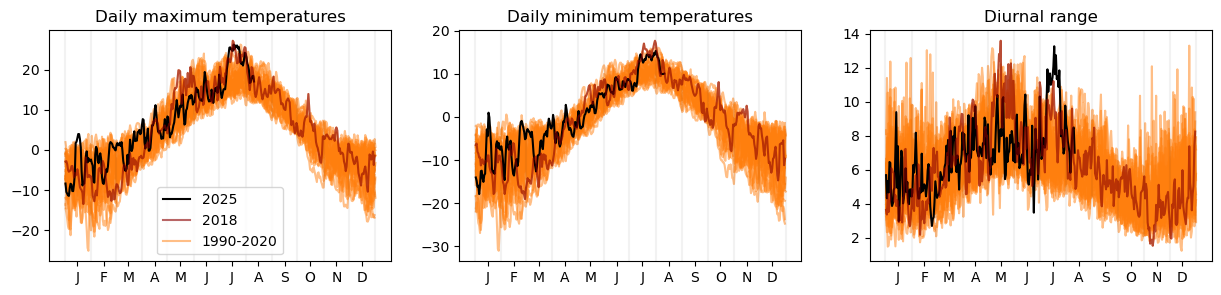

# Station data

## SMHI stations via Claire Bergin

In [ ]:
stn_se = pd.read_excel("data/stations/Sweden_Stns_details.xlsx", index_col = "Ide")

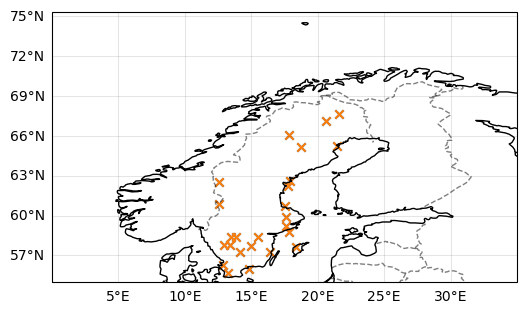

In [10]:
fig, ax = plt.subplots(figsize = (6,6), subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, dpi = 100)

for rt in ["min", "max"]:
    ax.scatter(stn_se.Longitude, stn_se.Latitude, marker = "x")

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

In [ ]:
fl = glob.glob("data/stations/*.csv")

In [40]:
tmax = []; tmin = []
for fnm in fl:
    df = pd.read_csv(fnm, header = None, names = ["start", "end", "date","tmin","qmin", "tmax","qmax"], index_col = "date", parse_dates = ["date"], dayfirst = True)
    tmax.append(df[["tmax"]].rename(columns = {"tmax" : fnm.split("_")[3]}))
    tmin.append(df[["tmin"]].rename(columns = {"tmin" : fnm.split("_")[3]}))

tmax = merge_byindex(tmax).dropna(axis = 0, how = "all")
tmin = merge_byindex(tmin).dropna(axis = 0, how = "all")

In [ ]:
tmax.to_csv("data/stations-smhi_tmax_claire.csv")
tmin.to_csv("data/stations-smhi_tmin_claire.csv")

In [45]:
tmin

74440  74180  97530  127130  180760  83230  78400  97120  127380  \
date                                                                           
1941-01-14    NaN    NaN    NaN     NaN   -27.9    NaN    NaN    NaN   -19.4   
1941-01-15    NaN    NaN    NaN     NaN   -32.9    NaN    NaN    NaN   -23.8   
1941-01-16    NaN    NaN    NaN     NaN   -37.0    NaN    NaN    NaN   -19.8   
1941-01-17    NaN    NaN    NaN     NaN   -37.5    NaN    NaN    NaN   -20.0   
1941-01-18    NaN    NaN    NaN     NaN   -35.9    NaN    NaN    NaN   -20.0   
...           ...    ...    ...     ...     ...    ...    ...    ...     ...   
2025-08-01   10.7    6.1   14.3    17.8    13.6   15.2   13.9   15.5    16.2   
2025-08-02   10.7    9.3   15.7    18.1    14.4   15.7   13.5   14.0    16.2   
2025-08-03   13.0    9.5   14.3    17.5    13.4   12.2   14.4   16.9     NaN   
2025-08-04   13.4   14.5   15.8    16.1    14.0   15.3   15.9   16.7     NaN   
2025-08-05   11.9   13.4   14.4    14.5    15.6   12.9   13.6   14.2    14.8   

            62180  ...  105370  122330  107440  85240  87450  102540  83270  \
date               ...                                                        
1941-01-14    NaN  ...   -11.5   -38.0     NaN    NaN   -9.5     NaN   -9.3   
1941-01-15    NaN  ...   -27.0   -40.6     NaN    NaN  -12.8     NaN  -21.0   
1941-01-16    NaN  ...   -27.0   -33.2     NaN    NaN  -10.0     NaN  -16.4   
1941-01-17    NaN  ...   -12.6   -29.8     NaN    NaN   -8.0     NaN  -10.1   
1941-01-18    NaN  ...   -22.4   -35.9     NaN    NaN  -10.5     NaN  -15.7   
...           ...  ...     ...     ...     ...    ...    ...     ...    ...   
2025-08-01   11.0  ...    13.2    13.8    16.8    NaN   17.0    15.0   13.0   
2025-08-02   11.4  ...    17.1     8.7    17.4    NaN   17.7    13.3   15.0   
2025-08-03   13.1  ...    13.9    12.3    16.9    NaN   18.1    12.9   12.4   
2025-08-04   14.9  ...    15.5    13.4    16.6    NaN   17.8    12.9   14.5   
2025-08-05   15.2  ...    14.0     9.7    15.6    NaN   14.9    12.1   12.5   

            181900  76160  72450  
date                              
1941-01-14     NaN    NaN   -7.5  
1941-01-15     NaN    NaN  -19.5  
1941-01-16     NaN    NaN  -23.5  
1941-01-17     NaN    NaN  -12.5  
1941-01-18     NaN    NaN  -11.5  
...            ...    ...    ...  
2025-08-01    15.0   10.7   11.3  
2025-08-02    14.3   10.8    NaN  
2025-08-03    14.9   10.8    NaN  
2025-08-04    14.0   11.6    NaN  
2025-08-05    16.0   14.8   12.8  

[30885 rows x 26 columns]

## ECAD stations (Sweden)

### Identify stations with long time series

In [39]:
def latlon_to_decimal(s): 
    dd,mm,ss = [int(x) for x in s.split(":")]
    return (dd + mm/60 + ss/3600)

In [63]:
df = pd.read_csv("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/ecad-stations.txt", skiprows = 18, header = None,
                 names = ["id", "station", "country", "mlat", "mlon", "elev"], index_col = "id")
df["country"] = [c.strip() for c in df.country]

df["lat"] = [latlon_to_decimal(l) for l in df.mlat]
df["lon"] = [latlon_to_decimal(l) for l in df.mlon]

df = df.loc[df.country.isin(["SE", "NO", "FI"])]
df["station"] = [s.strip() for s in df.station]

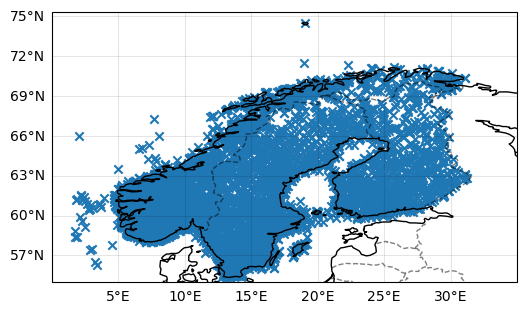

In [7]:
fig, ax = plt.subplots(figsize = (6,6), subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, dpi = 100)

ax.scatter(df.lon, df.lat, marker = "x")

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

In [8]:
fl = glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/ECA_non-blended_custom_sweden/*.txt")

In [50]:
stn_obs = {}
for fnm in fl:
    sdf = pd.read_csv(fnm, skiprows = 19)
    dr = sdf.loc[sdf['   TX'] > -999, '    DATE']
    stn_obs[fnm.split("SOUID")[-1][:-4]] = {"id" : sdf[' STAID'][0], "min" : dr.min(), "max" : dr.max(), "nobs" : dr.count()}

stn_obs = pd.DataFrame.from_dict(stn_obs).transpose()

In [ ]:
stn_looong = stn_obs.loc[(stn_obs["min"] < 19500000) * (stn_obs["max"] > 20250000)]
df_looong = pd.merge(df, stn_looong, left_index = True, right_on = "id")
df_looong.to_csv("data/ecad-long-stations_sweden.csv")

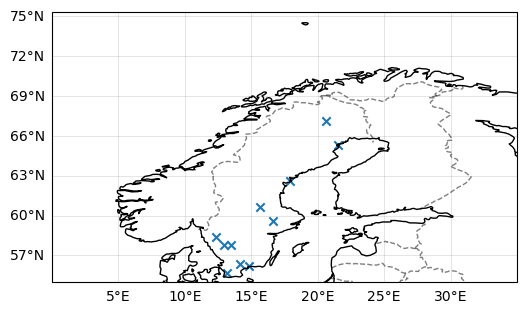

In [65]:
fig, ax = plt.subplots(figsize = (6,6), subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, dpi = 100)

ax.scatter(df_looong.lon, df_looong.lat, marker = "x")

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])

### Extract long time series

In [ ]:
df = pd.read_csv("data/ecad-long-stations_sweden.csv", index_col = 0)
n_stn = len(df)

long_ts = []
# nc = 4; nr = int(np.ceil(n_stn/nc))
# fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100)

for i in range(n_stn):
    # ax = axs.flatten()[i]
    stn_id = str(df.index[i])

    # ax.set_title("SOUID"+stn_id)

    ts = pd.read_csv("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/FS_heat/ECA_non-blended_custom_sweden/TX_SOUID"+stn_id+".txt", skiprows = 19, parse_dates = ['    DATE'])
    ts.columns = [c.strip() for c in ts.columns]
    ts["TX"] = ts.TX / 10
    ts = ts.loc[ts.TX > -99]
    long_ts.append(ts.set_index("DATE")[["TX"]].rename(columns = {"TX" : stn_id}))

long_ts = merge_byindex(long_ts)
long_ts.to_csv("data/ecad-long-tx_sweden.csv")

### Plot

In [38]:
df = pd.read_csv("data/ecad-long-tx_sweden.csv", index_col = "DATE", parse_dates = ["DATE"])
n_stn = len(df.columns)
nc = 4; nr = int(np.ceil(n_stn/nc))

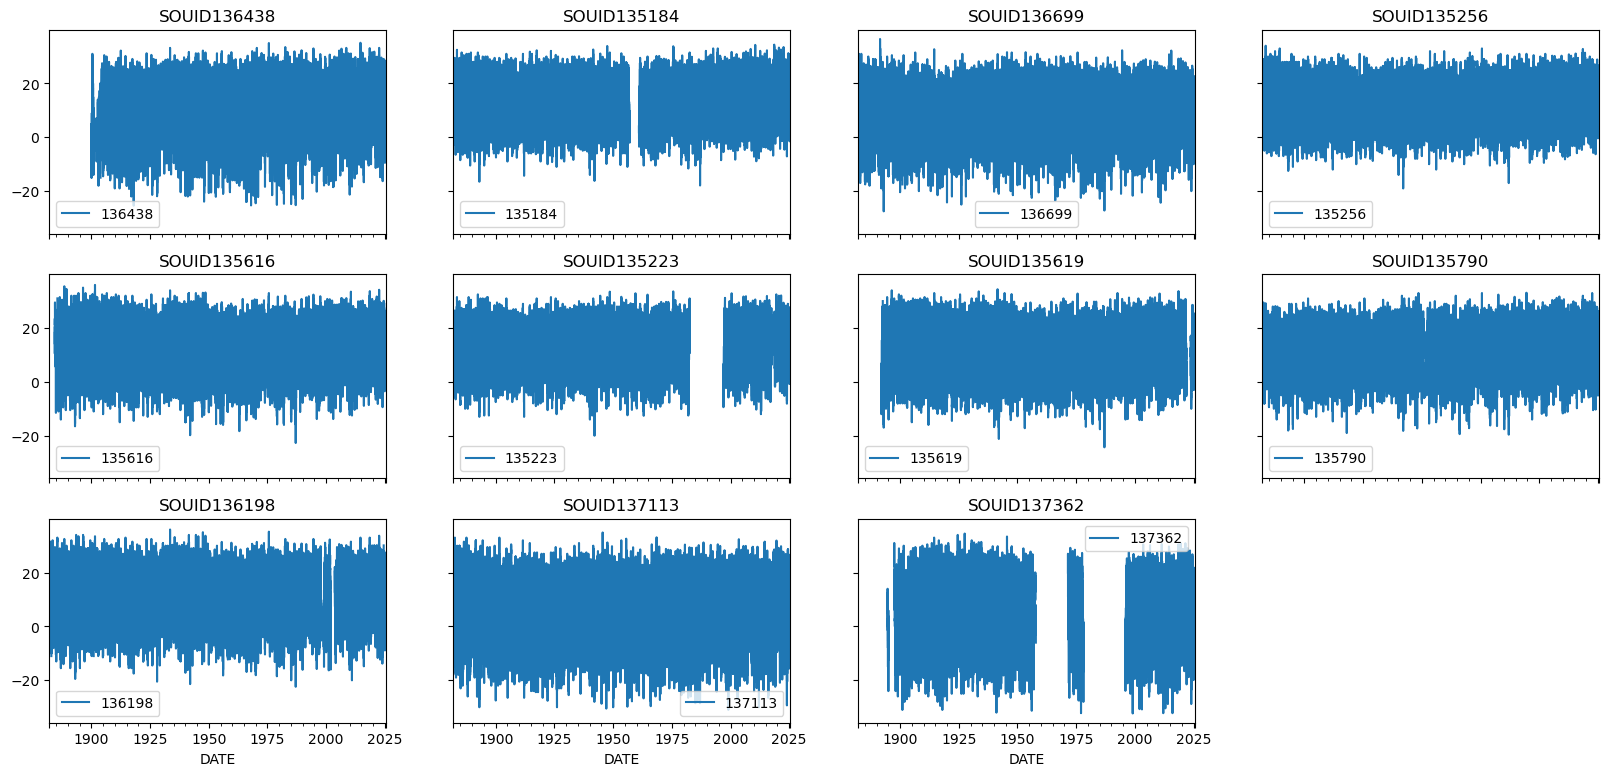

In [41]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100, sharex = True, sharey = True)

for i in range(n_stn):
    ax = axs.flatten()[i]
    stn_id = str(df.columns[i])

    ax.set_title("SOUID"+stn_id)
    df[[stn_id]].plot(ax = ax, label = "_")

for i in range(n_stn, nc*nr): axs.flatten()[i].set_axis_off()

plt.savefig("fig/station-availability_ecad-sweden-long.png")